> ## **[개요]**

- 목적 : 자율주행차의 Radar 생산 과정에서의 공정 데이터를 통해 Radar의 최종 성능 예측
- 활용 데이터 ('train.csv' data 참고)   
   - 자율 주행 센서 제조 공정에서 수집된 데이터 (39,607건)
   - X Feature (56개) : 자율주행 센서 조립 공정에서 세팅한 인자값 
   - Y Feature (14개) : 최종 센서의 성능

- 데이터 전처리
  - 결측치가 존재하는 경우 해당 행은 제거 
  - 모두 동일한 값을 가지는 column 제거 (특정 feature가 모든 샘플에 같은 상수 값을 가짐)
  - column끼리 비교하여 같은 값을 가지는 column들이 있다면 제거 

- 데이터 시각화
  - 데이터 구조를 파악하여 특징 확인 (head, columns, unique, describe, info)
  - 이상치나 노이즈를 확인하기 위해 데이터 분포 시각화 및 기초 통계량 확인
  - 각 특성 분포를 시각화하여 데이터 특성 파악

- 모델 선택과 학습
  1. Feature Scaling 
     - Standardization
  
  2. 모델 선택 
     - Regression(Lidge)
     - Random Forest 
     - XGBoost
     - LightGBM
     - 위의 결과를 토대로 Voting, Bagging, Stacking 진행 (미정) 
  
  3. 모델 학습
     - 데이터를 학습, 검증, 테스트셋을 6:2:2로 나누어 학습
     - Hyper parameter tuning이 필요한 경우, Stratified K-Fold와 GridSearchCV를 이용해서 Tuning

  4. 모델 평가
     - 성능 평가를 위해 MSE 또는 RMSE 사용 
  
  5. 모델 최적화와 향상
     - 새로운 변수 생성을 통한 모델 성능 향상
          

## **준비**

### [데이터 수집 및 로드]

- 데이터 수집: 자율주행 센서의 안테나 성능 (출처: LG AI Research)

   [데이터 출처](https://dacon.io/competitions/official/235927/overview/description)



In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
df = pd.read_csv('train.csv')

### [데이터 전처리]

---
데이터 결측치 확인

In [69]:
def check_null_count(df):
    null_sum = df.isnull().sum()
    return len(null_sum[null_sum!=0])

check_null_count(df)

0

---
모두 같은 상수 값을 가지는 column 제거

In [70]:
def remove_uniform_col(df):
    columns_to_remove = [col for col in df.columns if df[col].nunique() == 1]
    print('제거된 열:', columns_to_remove)
    return df.drop(columns = columns_to_remove)

df = remove_uniform_col(df)

제거된 열: ['X_04', 'X_23', 'X_47', 'X_48']


---
column끼리 비교하여 같은 값을 가지는 column들이 있다면 제거 

In [71]:
def check_duplicate_columns(df):
    return df.loc[:, ~df.T.duplicated()]

df = check_duplicate_columns(df)

데이터 전처리 과정을 통해 아래 내용을 파악했습니다.

- isnull().sum() 이용, 해당 데이터에 결측치가 없음을 확인했습니다.
- nunique()==1 이용, 값이 전부 동일한 상수인 X_04, X_23, X_47, X_48을 확인 후 제거했습니다. (n차 중간 검사 통과 여부)
- drop_duplicates()이용, 같은 값을 가지는 column이 없음을 확인했습니다.  

## **EDA**

### <EDA 가이드>
- 데이터의 구조, 패턴, 이상치, 상관 관계 등을 파악
- 시각화 도구를 사용하여 데이터를 분석 
- 모델의 성능을 향상시키기 위해 Feature를 선택, 변환, 생성 
- 데이터의 정보를 최대한 활용

In [52]:
df.head()

ID    X_01     X_02   X_03     X_05    X_06   X_07    X_08  \
0  TRAIN_00001  70.544  103.320  67.47  101.892  74.983  29.45   62.38   
1  TRAIN_00002  69.524  103.321  65.17  101.944  72.943  28.73   61.23   
2  TRAIN_00003  72.583  103.320  64.07  103.153  72.943  28.81  105.77   
3  TRAIN_00004  71.563  103.320  67.57  101.971  77.022  28.92  115.21   
4  TRAIN_00005  69.524  103.320  63.57  101.981  70.904  29.68  103.38   

     X_09  X_10  ...    Y_05    Y_06   Y_07    Y_08    Y_09    Y_10    Y_11  \
0  245.71   0.0  ...  29.632  16.083  4.276 -25.381 -25.529 -22.769  23.792   
1  233.61   0.0  ...  33.179  16.736  3.229 -26.619 -26.523 -22.574  24.691   
2  272.20   0.0  ...  31.801  17.080  2.839 -26.238 -26.216 -22.169  24.649   
3  255.36   0.0  ...  34.503  17.143  3.144 -25.426 -25.079 -21.765  24.913   
4  241.46   0.0  ...  32.602  17.569  3.138 -25.376 -25.242 -21.072  25.299   

     Y_12    Y_13    Y_14  
0 -25.470 -25.409 -25.304  
1 -26.253 -26.497 -26.438  
2 -26.285 -26.215 -26.370  
3 -25.254 -25.021 -25.345  
4 -25.072 -25.195 -24.974  

[5 rows x 67 columns]

1) ID columns은 str 데이터이며 오름차순으로 되어있음 
2) 이외 변수는 실수형 데이터로 구성돼있음 

---  

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39607 entries, 0 to 39606
Data columns (total 67 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      39607 non-null  object 
 1   X_01    39607 non-null  float64
 2   X_02    39607 non-null  float64
 3   X_03    39607 non-null  float64
 4   X_05    39607 non-null  float64
 5   X_06    39607 non-null  float64
 6   X_07    39607 non-null  float64
 7   X_08    39607 non-null  float64
 8   X_09    39607 non-null  float64
 9   X_10    39607 non-null  float64
 10  X_11    39607 non-null  float64
 11  X_12    39607 non-null  float64
 12  X_13    39607 non-null  float64
 13  X_14    39607 non-null  float64
 14  X_15    39607 non-null  float64
 15  X_16    39607 non-null  float64
 16  X_17    39607 non-null  float64
 17  X_18    39607 non-null  float64
 18  X_19    39607 non-null  float64
 19  X_20    39607 non-null  float64
 20  X_21    39607 non-null  float64
 21  X_22    39607 non-null  float64
 22

1) int → X_46 : 실란트 본드 소요량
2) object → ID

--- 

In [54]:
df.select_dtypes(include=int)

X_46
0      1463
1      1463
2      1468
3      1469
4      1469
...     ...
39602  1469
39603  1458
39604  1459
39605  1469
39606  1462

[39607 rows x 1 columns]

In [55]:
df.describe()

X_01          X_02          X_03          X_05          X_06  \
count  39607.000000  39607.000000  39607.000000  39607.000000  39607.000000   
mean      68.412040    103.320166     68.826354    102.337203     70.597211   
std        2.655983      0.000372      5.151167      0.548353      2.259820   
min       56.268000    103.320000     56.470000    101.774000     61.726000   
25%       66.465000    103.320000     65.070000    101.949000     68.864000   
50%       68.504000    103.320000     67.270000    102.006000     69.884000   
75%       69.524000    103.320000     71.770000    103.144000     71.923000   
max       84.820000    103.321000     89.170000    103.160000     87.219000   

               X_07          X_08          X_09          X_10          X_11  \
count  39607.000000  39607.000000  39607.000000  39607.000000  39607.000000   
mean      29.407490    164.449320    225.397470      0.002449      0.000366   
std        7.338204    220.402444     66.734725      0.086255      0.014145   
min       14.140000     38.460000     37.580000      0.000000      0.000000   
25%       27.890000    105.990000    188.540000      0.000000      0.000000   
50%       28.840000    115.040000    234.450000      0.000000      0.000000   
75%       29.870000    132.620000    263.960000      0.000000      0.000000   
max      163.860000   2387.440000    637.490000      3.600000      0.700000   

       ...          Y_05          Y_06          Y_07          Y_08  \
count  ...  39607.000000  39607.000000  39607.000000  39607.000000   
mean   ...     31.290467     16.529382      3.155054    -26.294839   
std    ...      2.543222      1.893014      0.418940      0.660537   
min    ...     18.589000    -19.963000      0.502000    -29.652000   
25%    ...     29.768000     16.146000      2.863000    -26.689000   
50%    ...     31.710000     16.694000      3.126000    -26.254000   
75%    ...     33.184000     17.164000      3.433500    -25.855000   
max    ...     37.250000     18.998000      5.299000    -23.785000   

               Y_09          Y_10          Y_11          Y_12          Y_13  \
count  39607.000000  39607.000000  39607.000000  39607.000000  39607.000000   
mean     -26.308623    -22.400062     24.325061    -26.237762    -26.233869   
std        0.653580      0.920952      0.830197      0.656329      0.655090   
min      -29.523000    -31.119000     19.844000    -29.544000    -29.448000   
25%      -26.702000    -22.871000     23.836000    -26.630000    -26.624000   
50%      -26.266000    -22.275000     24.420000    -26.198000    -26.193000   
75%      -25.871000    -21.791000     24.911500    -25.799000    -25.794000   
max      -23.960000    -20.052000     26.703000    -23.722000    -23.899000   

               Y_14  
count  39607.000000  
mean     -26.245868  
std        0.655989  
min      -29.620000  
25%      -26.640000  
50%      -26.204000  
75%      -25.809000  
max      -23.856000  

[8 rows x 66 columns]

### [X 분포 확인]

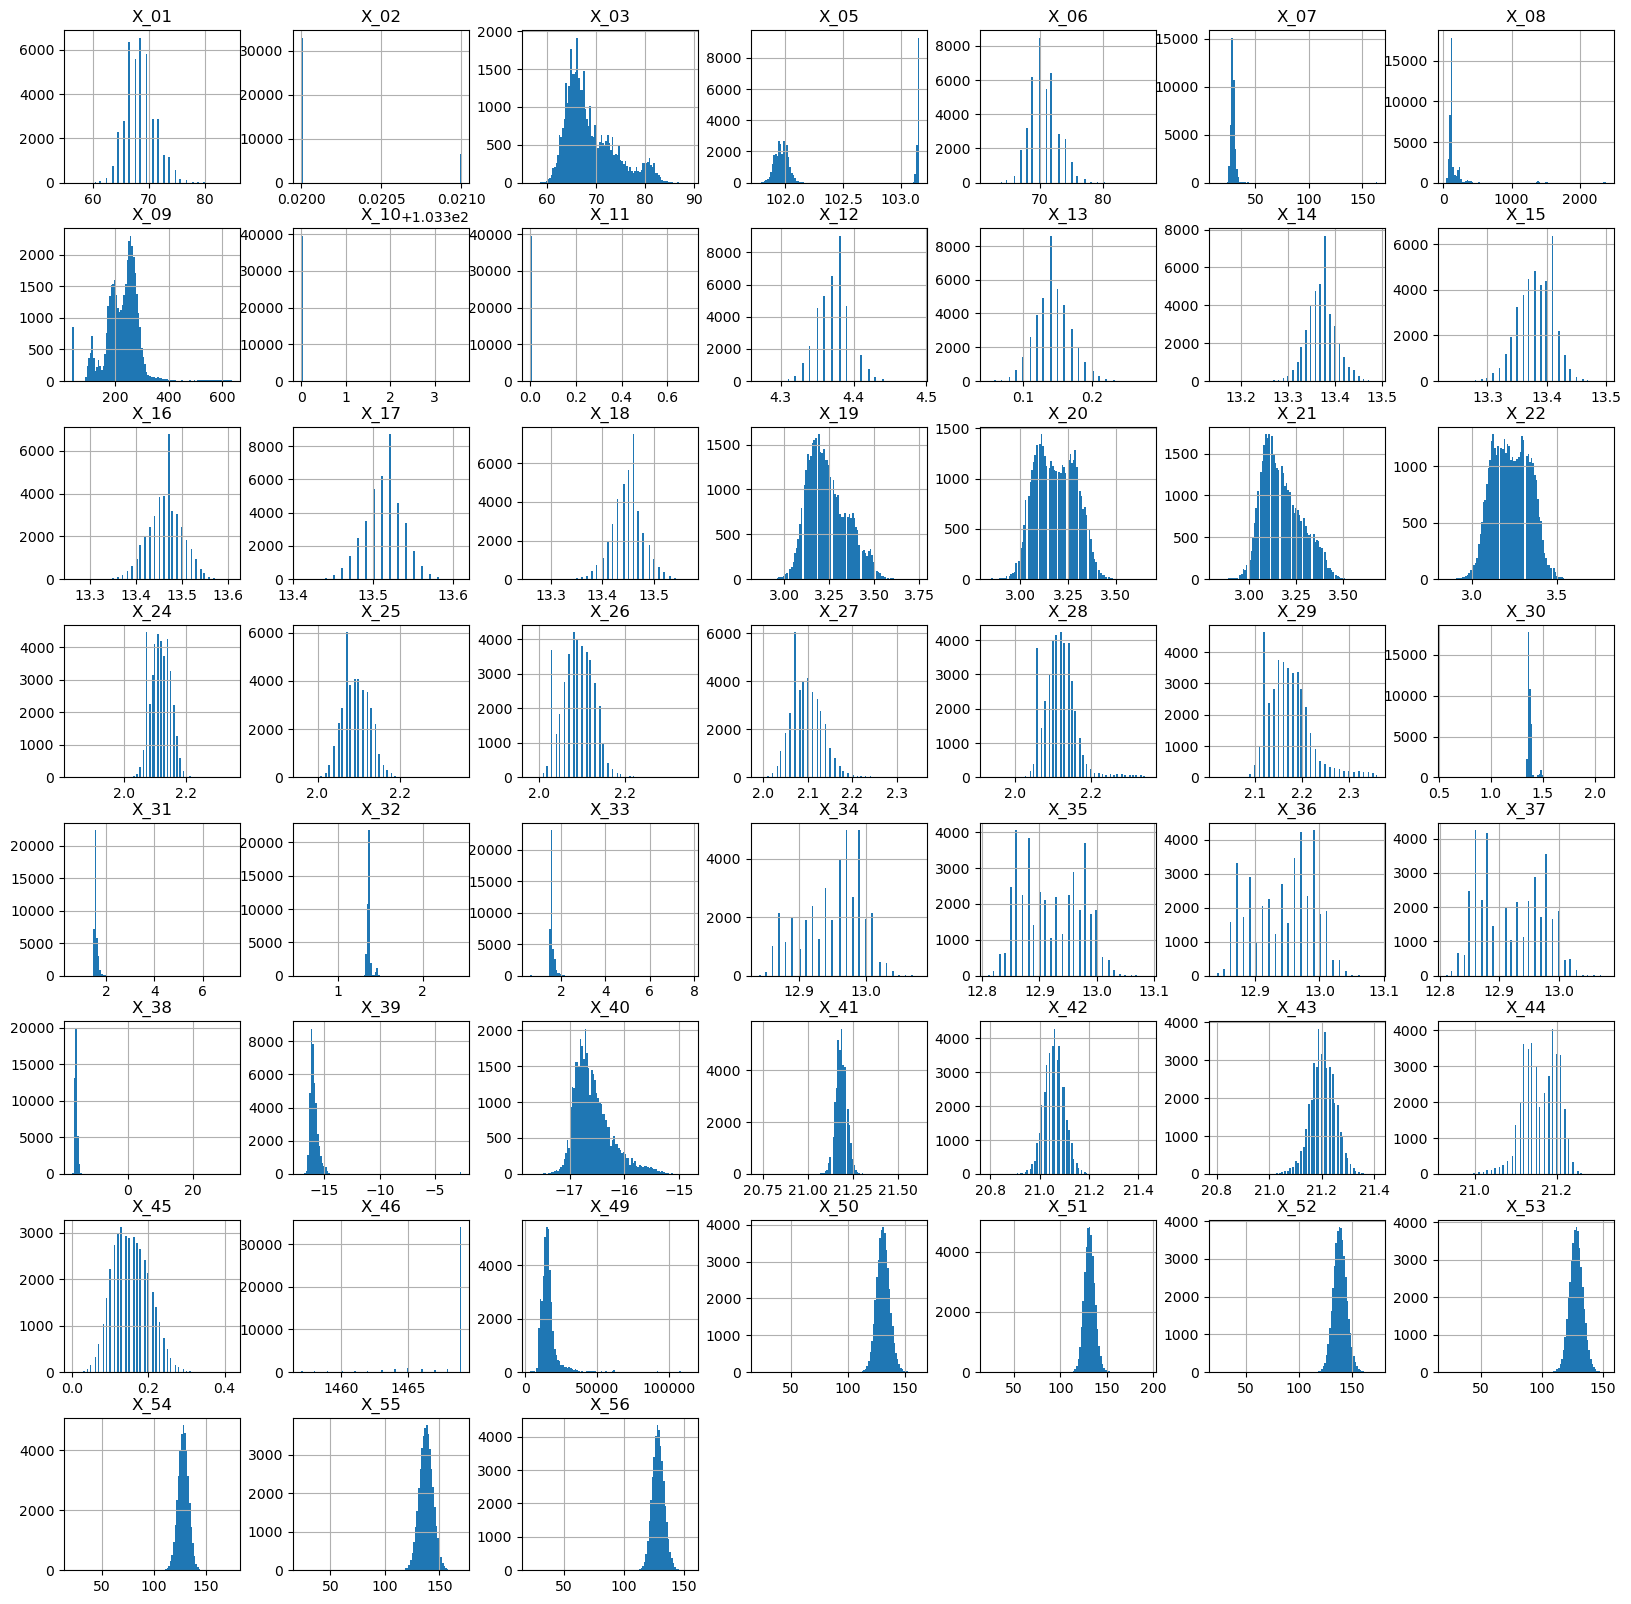

In [56]:
x_feature = df.filter(regex='^X_*')
x_feature.hist(bins=100, figsize=(20, 20))
plt.show()

### [이상 Feature 데이터 확인]

In [72]:
abnormal_feature =['X_02', 'X_10', 'X_11', 'X_46']

for abf in abnormal_feature:
    feauter_vc = df[abf].value_counts()
    print(abf)
    print(feauter_vc)
    print()

X_02
103.320    33020
103.321     6587
Name: X_02, dtype: int64

X_10
0.0    39575
2.9       12
3.0       12
3.3        4
3.1        2
3.6        1
3.2        1
Name: X_10, dtype: int64

X_11
0.0    39580
0.5       12
0.6       11
0.4        3
0.7        1
Name: X_11, dtype: int64

X_46
1469    34088
1465      881
1464      780
1468      696
1466      610
1463      549
1467      389
1462      365
1461      308
1460      305
1459      259
1458      197
1457      180
Name: X_46, dtype: int64



In [73]:
df['X_46'].nunique()

13

In [74]:
x_02_vc = df['X_02'].value_counts().reset_index()
x_02_vc.columns = ['name', 'value']

import plotly.express as px

fig = px.pie(data_frame=x_02_vc, names='name', values='value')
fig.update_traces(hole=.3)
fig.show()

In [75]:
x_46_vc = df['X_46'].value_counts().reset_index()
x_46_vc.columns = ['name', 'value']

import plotly.express as px

fig = px.pie(data_frame=x_46_vc, names='name', values='value')
fig.update_traces(hole=.3)
fig.show()

In [76]:
y_feature_list = list(df.filter(regex='^Y_*'))
abnormal_feature =['X_02', 'X_10', 'X_11', 'X_46']
y_feature_list.extend(abnormal_feature)

### [이상 Feature 상관도 확인]

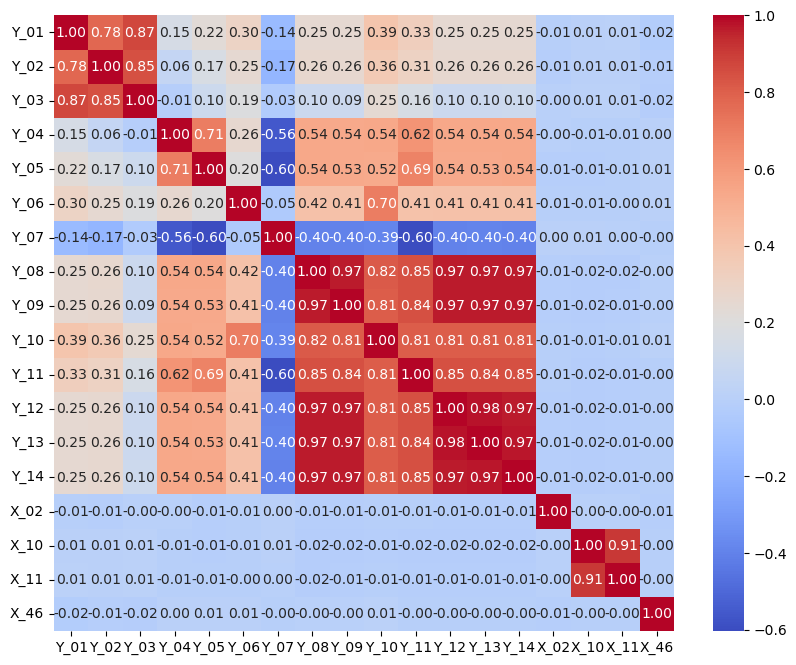

In [77]:
# 상관 계수 행렬 계산
corr = df[y_feature_list].corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()


1. X_02 (PCB 체결시 단계별 누름량)은 2개의 값으로 이루어짐 
2. X_10 (방열재료 2의 무게)과 X_11(방열재료 3의 무게)의 데이터의 99.9%가 0.0에 몰려있어 결측치로 의심됨
   
   하지만 의미있는 값일수도 있기때문에 모델을 학습 후 변수 중요도를 확인 후 제외할 예정임
3. X_46 (실란트 본드 소요량)은 86.1% 값이 1469로 편중되어있음
4. 해당 데이터들이 한 값으로 편중돼 있으나 Y값과 상관 관계가 없음으로 해당Column 제거

### [Feature 제거]

In [78]:
df=df.drop(abnormal_feature, axis=1)


### [Feature 제거 후 분포&Box Plot 확인]

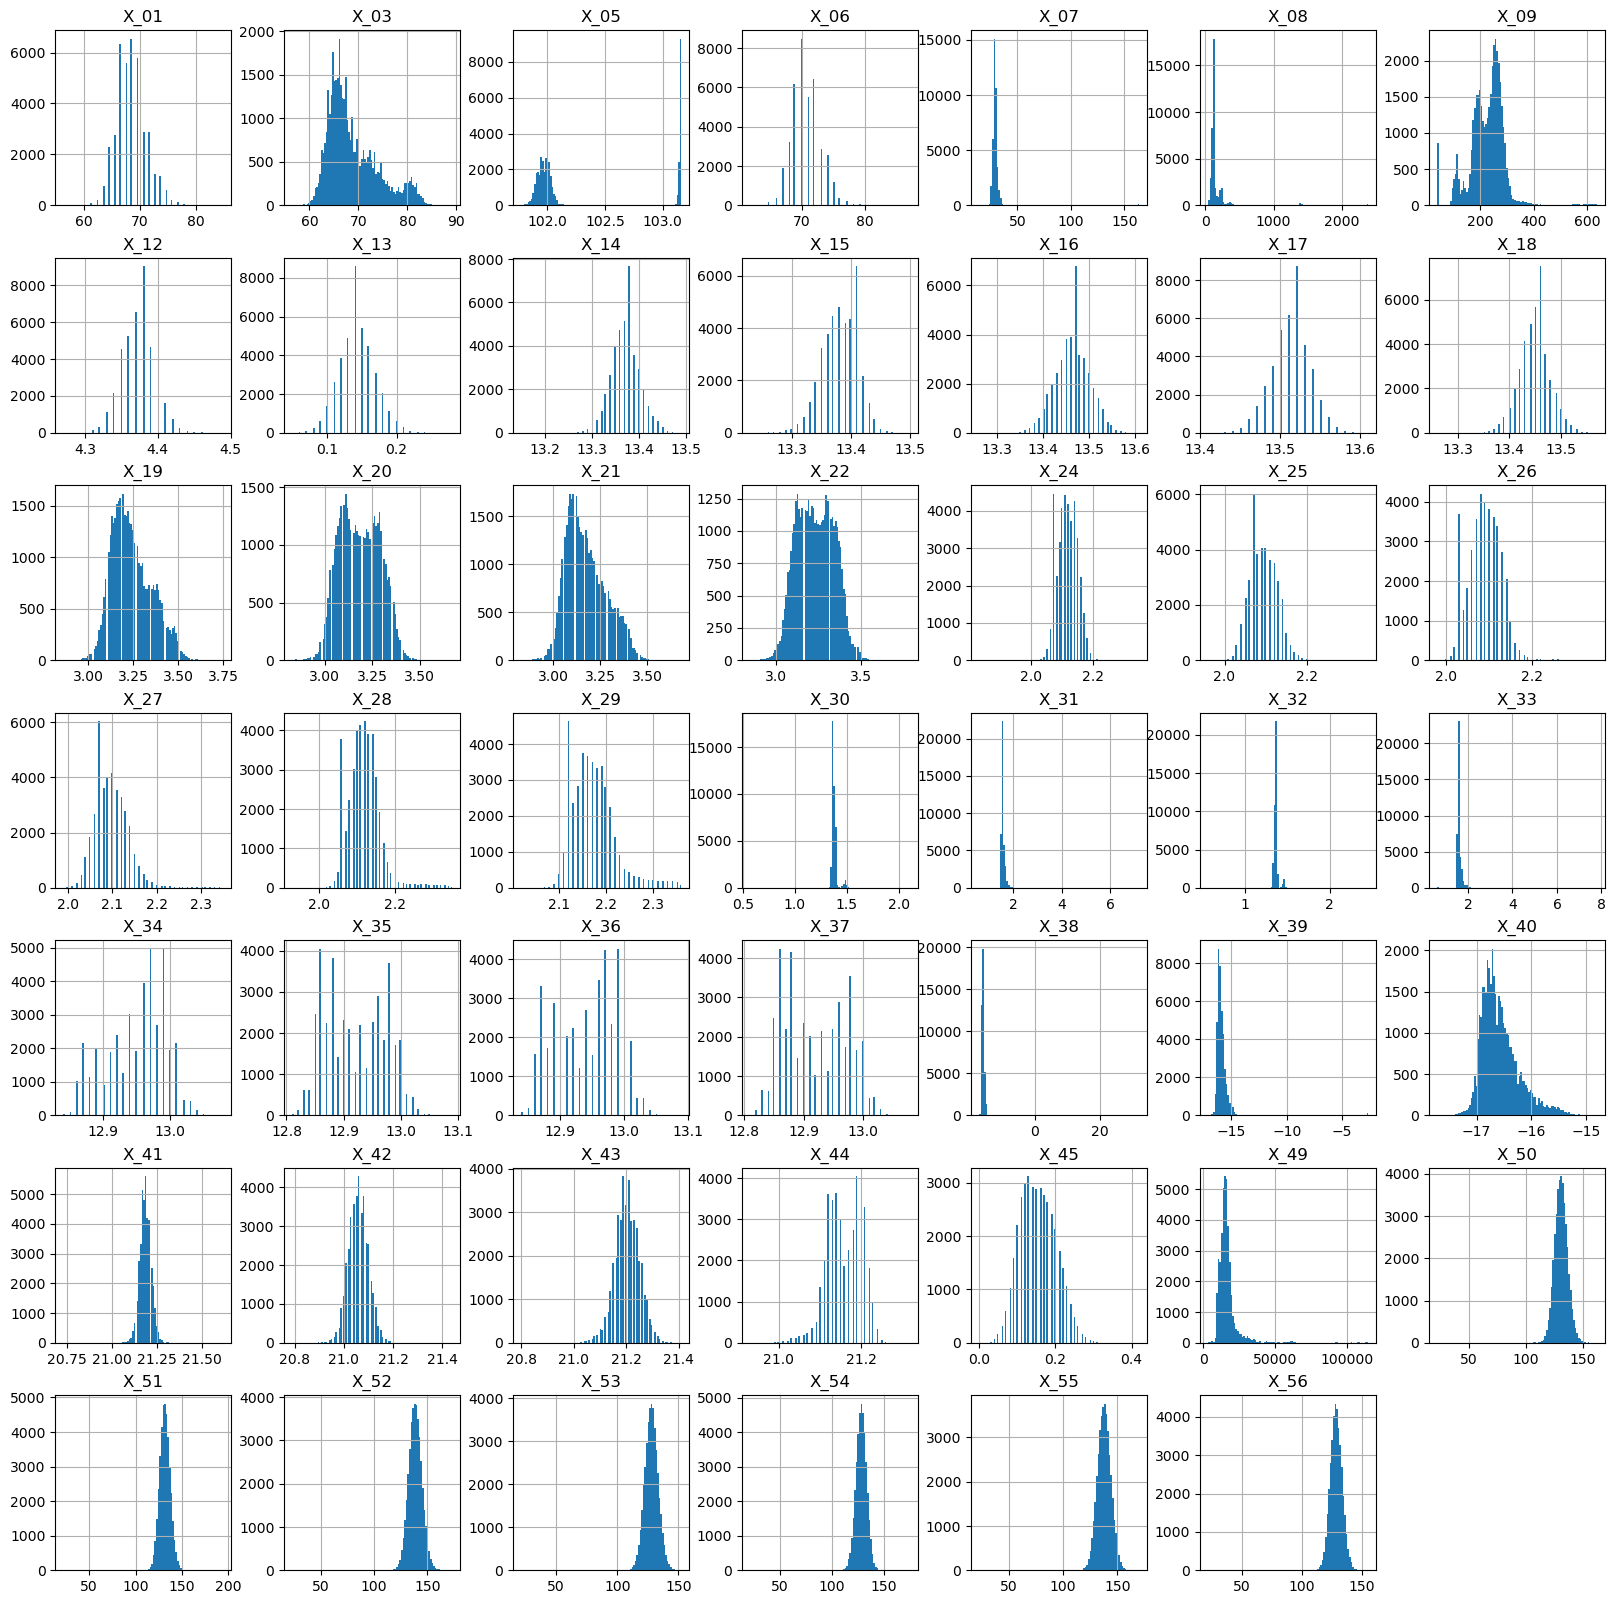

In [18]:
x_feature = df.filter(regex='^X_*')
x_feature.hist(bins=100, figsize=(20, 20))
plt.show()

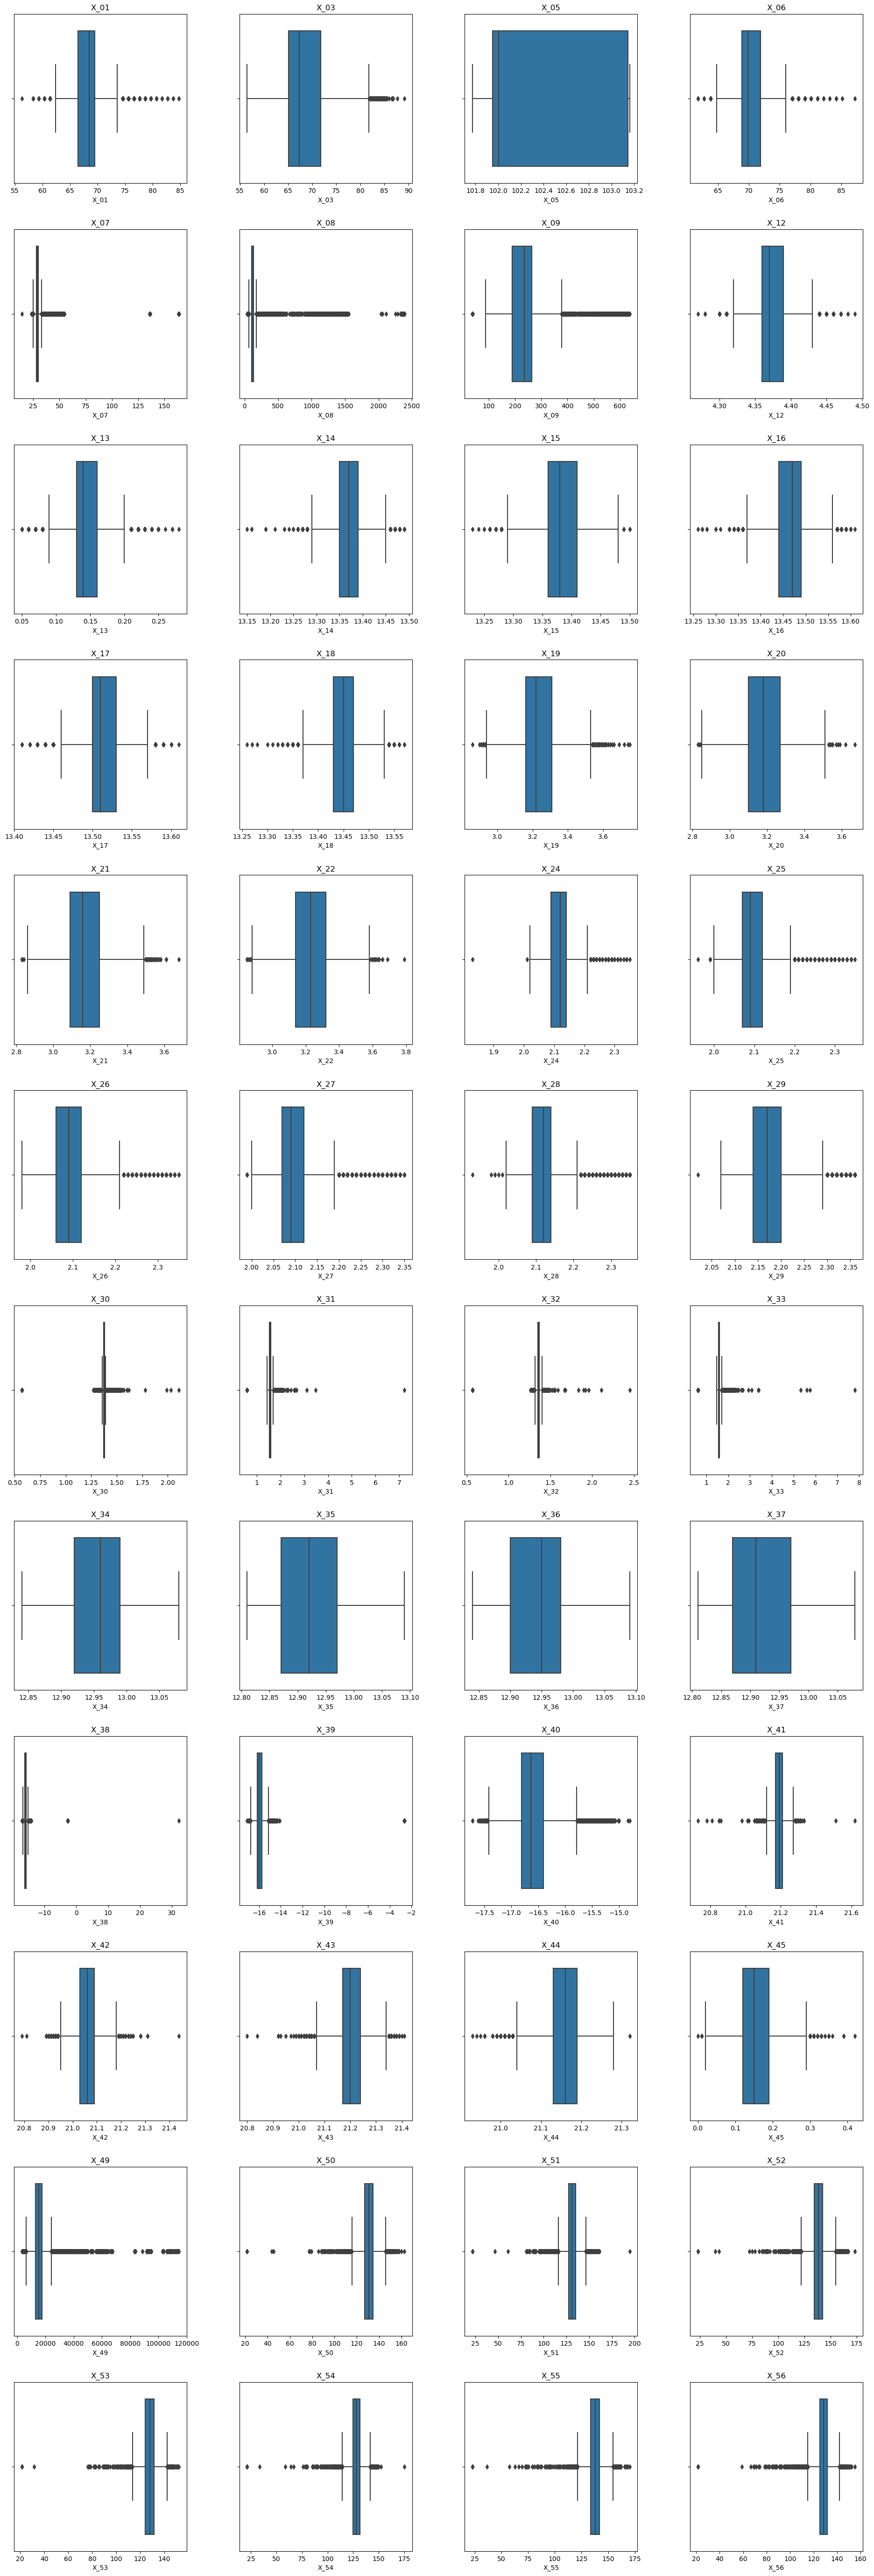

In [19]:

# 총 56개의 subplot 생성 (가로 4개, 세로 14개)
fig, axs = plt.subplots(nrows=len(x_feature.columns)//4, ncols=4, figsize=(20, 56))
fig.tight_layout(pad=5.0)

# 각 컬럼에 대한 박스플롯 그리기
for i, column in enumerate(x_feature.columns):
    row = i // 4
    col = i % 4
    sns.boxplot(x=x_feature[column], ax=axs[row, col])
    axs[row, col].set_title(column)

plt.show()


해당 이상치들을 다 빼는 것이 맞는가??

일단은 빼지말자 하하

### [Y 분포 및 Box Plot 확인]

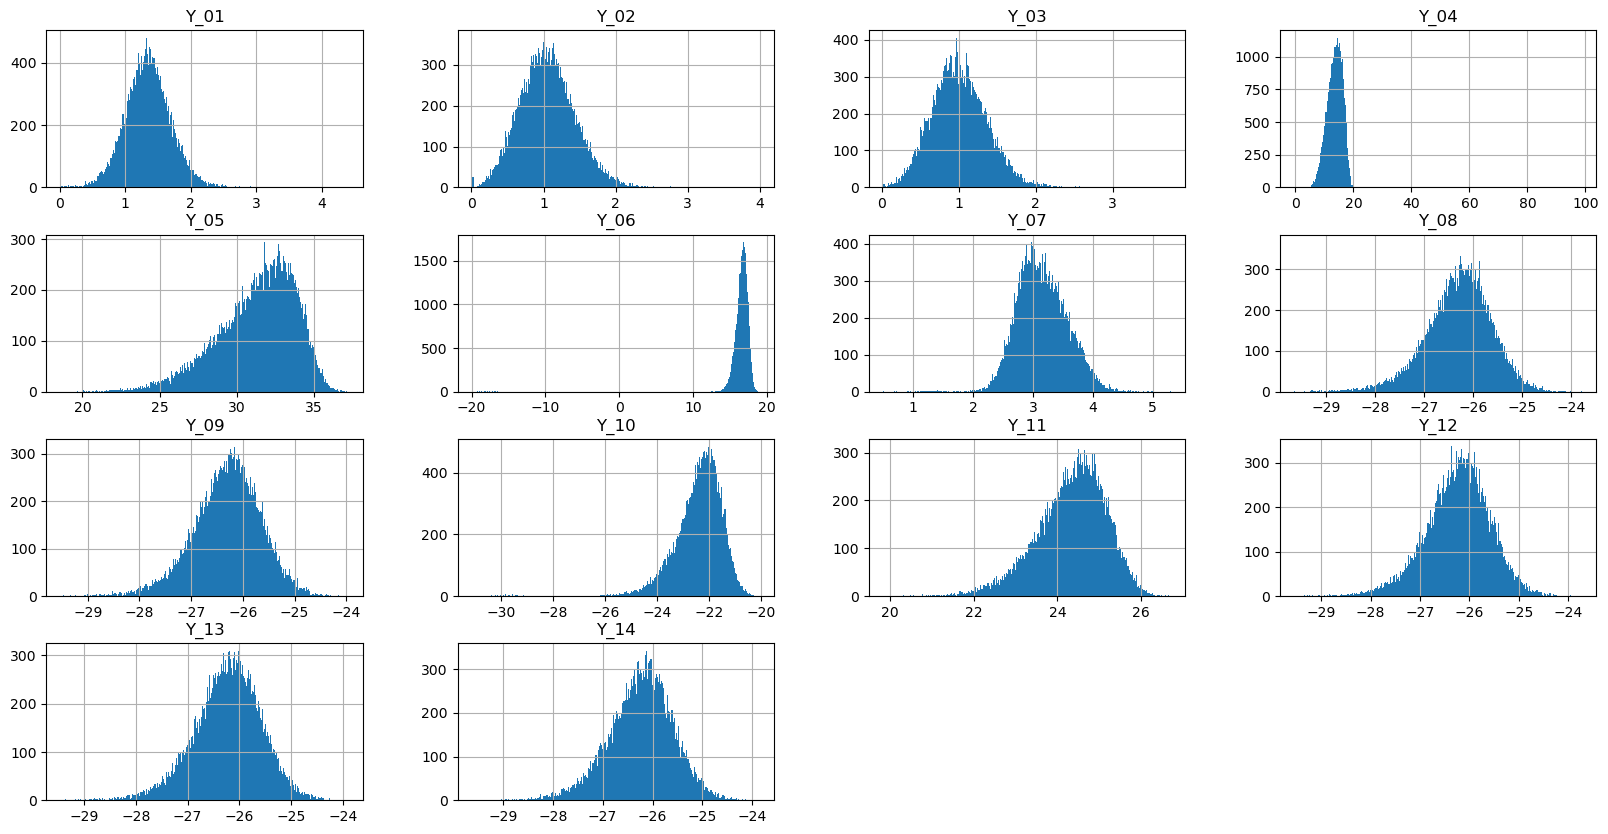

In [20]:
y_feature = df.filter(regex='^Y_*')
y_feature.hist(bins=500, figsize=(20, 10))
plt.show()

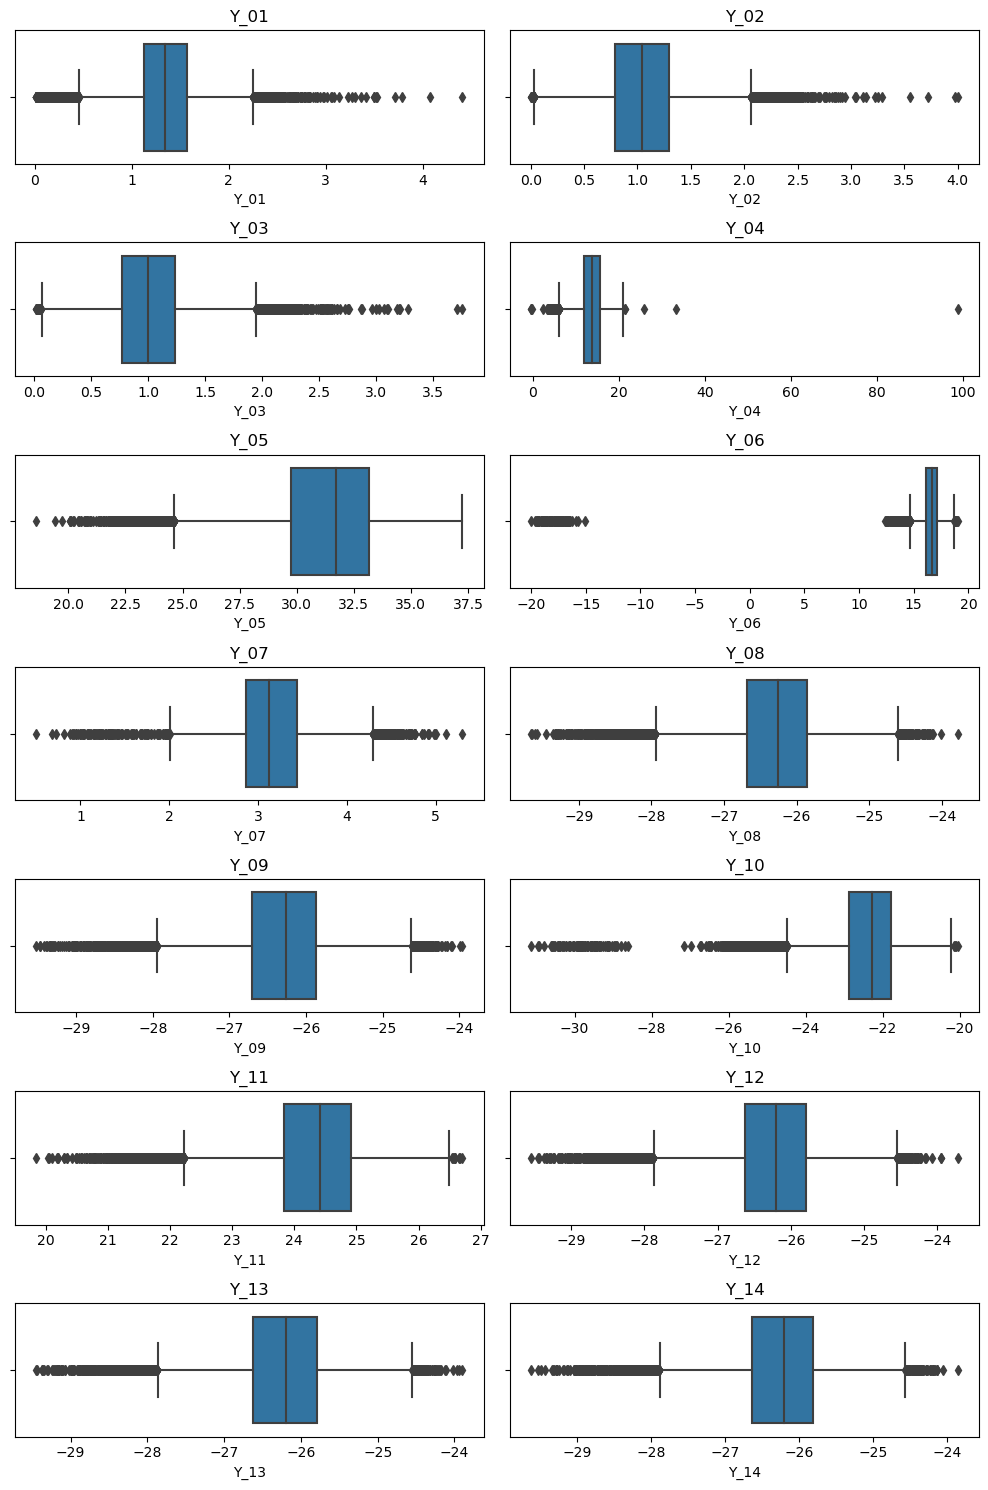

In [21]:
# 총 14개의 subplot 생성 (가로 4개, 세로 4개)
fig, axs = plt.subplots(nrows=len(y_feature.columns)//2, ncols=2, figsize=(10, 15))
fig.tight_layout(pad=5.0)

# 각 컬럼에 대한 박스플롯 그리기
for i, column in enumerate(y_feature.columns):
    row = i // 2
    col = i % 2
    sns.boxplot(x=y_feature[column], ax=axs[row, col])
    axs[row, col].set_title(column)
plt.tight_layout()
plt.show()

## **모델**

### [Train/Val/Test 나누기]

In [22]:
from sklearn.model_selection import train_test_split

x_train_val, x_test, y_train_val, y_test = train_test_split(x_feature, y_feature, test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val =train_test_split(x_train_val, y_train_val, test_size = 0.25, random_state=0)

print(f'x_train: {x_train.shape}, x_val: {x_val.shape}, x_test: {x_test.shape}')
print(f'y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}')

x_train: (23763, 48), x_val: (7922, 48), x_test: (7922, 48)
y_train: (23763, 14), y_val: (7922, 14), y_test: (7922, 14)


### [Scaling 진행]

In [23]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer

scaler = StandardScaler()
scaler.fit(x_train)

x_train_zscale = scaler.transform(x_train)
x_val_zscale = scaler.transform(x_val)
x_test_zscale = scaler.transform(x_test) 

### [Multi Output Regressor]

In [24]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

for alpha in [0, 0.5, 1, 3, 5, 10, 100, 1000]:
    regressor = MultiOutputRegressor(Ridge(alpha=alpha, random_state=0)).fit(x_train_zscale, y_train)
    y_val_pred_rg = regressor.predict(x_val_zscale)
    mse = mean_squared_error(y_val, y_val_pred_rg)
    print(f"{alpha, mse}") 

(0, 1.4493627345391087)
(0.5, 1.4493618751663708)
(1, 1.4493610179840057)
(3, 1.449357611017598)
(5, 1.449354238538891)
(10, 1.4493459553824635)
(100, 1.449227054013994)
(1000, 1.449151610304935)


In [135]:
for solver in ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']:
    regressor = MultiOutputRegressor(Ridge(solver=solver, random_state=0)).fit(x_train_zscale, y_train)
    y_val_pred_rg = regressor.predict(x_val_zscale)
    mse = mean_squared_error(y_val, y_val_pred_rg)
    print(f"{solver, mse}") 

('auto', 1.4493610179840057)
('svd', 1.4493610179840055)
('cholesky', 1.4493610179840057)
('lsqr', 1.449736936773706)
('sparse_cg', 1.4493621364673415)
('sag', 1.4493657557667217)
('saga', 1.449369171053885)


In [136]:
regressor = MultiOutputRegressor(Ridge(alpha=1000, solver='auto', random_state=0)).fit(x_train_zscale, y_train)
y_test_pred_rg = regressor.predict(x_test_zscale)
mse = mean_squared_error(y_test, y_test_pred_rg)
print(f"{mse}") 

1.5236600651505545


### [Random Forest]

In [25]:
from sklearn.ensemble import RandomForestRegressor

for n_estimator in [10, 50, 100, 200, 300]:
    rf_regressor = RandomForestRegressor(n_estimators=n_estimator, random_state=0)
    rf_regressor.fit(x_train_zscale, y_train)
    y_pred_rf = rf_regressor.predict(x_val_zscale)
    mse = mean_squared_error(y_val, y_pred_rf)
    print(f"{n_estimator, mse}")

(10, 1.5441822256357525)
(50, 1.4158361107350308)
(100, 1.4016666007107659)
(200, 1.3875726741719097)
(300, 1.386473567132701)


In [26]:
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
rf_regressor.fit(x_train_zscale, y_train)
y_pred_rf = rf_regressor.predict(x_test_zscale)
mse = mean_squared_error(y_test, y_pred_rf)
print(f"{mse}")

1.4705624057578264


### [LightGBM]

In [27]:
import lightgbm as lgb

lgbm_model = lgb.LGBMRegressor()
multioutput_model = MultiOutputRegressor(lgbm_model)
multioutput_model.fit(x_train_zscale, y_train)

y_pred_lgb = multioutput_model.predict(x_val_zscale)


mse = mean_squared_error(y_val, y_pred_lgb, multioutput='uniform_average')
print(f'Mean Squared Error: {mse}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5134
[LightGBM] [Info] Number of data points in the train set: 23763, number of used features: 48
[LightGBM] [Info] Start training from score 1.352875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5134
[LightGBM] [Info] Number of data points in the train set: 23763, number of used features: 48
[LightGBM] [Info] Start training from score 1.056001
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5134
[LightGBM] [Info] Number of data points in the train set: 23763, number of used features: 48
[LightGBM] [Info] Start tra

In [28]:
lgbm_model = lgb.LGBMRegressor()
multioutput_model = MultiOutputRegressor(lgbm_model)
multioutput_model.fit(x_train_zscale, y_train)

y_pred_lgb = multioutput_model.predict(x_test_zscale)


mse = mean_squared_error(y_test, y_pred_lgb, multioutput='uniform_average')
print(f'Mean Squared Error: {mse}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5134
[LightGBM] [Info] Number of data points in the train set: 23763, number of used features: 48
[LightGBM] [Info] Start training from score 1.352875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5134
[LightGBM] [Info] Number of data points in the train set: 23763, number of used features: 48
[LightGBM] [Info] Start training from score 1.056001
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5134
[LightGBM] [Info] Number of data points in the train set: 23763, number of used features: 48
[LightGBM] [Info] Start tra

In [29]:
from sklearn.model_selection import GridSearchCV

# LightGBM 모델 설정
lgbm_model = lgb.LGBMRegressor()

# 하이퍼 파라미터 그리드 설정
param_grid = {
    'estimator__num_leaves': [4, 16, 256],
    'estimator__max_depth': [2, 4, 8],
    'estimator__learning_rate': [0.01],
    'estimator__n_estimators': [500],
}

# GridSearchCV 설정
multioutput_model = MultiOutputRegressor(lgbm_model)
grid_search = GridSearchCV(multioutput_model, param_grid, cv=2, scoring='neg_mean_squared_error')

# 그리드 서치 실행
grid_search.fit(x_train_zscale, y_train) #Train+val 합쳐서 진행

# 최적의 파라미터와 성능 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)
pd.DataFrame(grid_search.cv_results_).T

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4999
[LightGBM] [Info] Number of data points in the train set: 11881, number of used features: 48
[LightGBM] [Info] Start training from score 1.352356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4999
[LightGBM] [

0  \
mean_fit_time                                                             3.57441   
std_fit_time                                                             0.032496   
mean_score_time                                                           0.54796   
std_score_time                                                           0.000992   
param_estimator__learning_rate                                               0.01   
param_estimator__max_depth                                                      2   
param_estimator__n_estimators                                                 500   
param_estimator__num_leaves                                                     4   
params                          {'estimator__learning_rate': 0.01, 'estimator_...   
split0_test_score                                                       -1.490499   
split1_test_score                                                       -1.505256   
mean_test_score                                                         -1.497878   
std_test_score                                                           0.007379   
rank_test_score                                                                 7   

                                                                                1  \
mean_fit_time                                                            3.646578   
std_fit_time                                                             0.047471   
mean_score_time                                                          0.546135   
std_score_time                                                           0.003498   
param_estimator__learning_rate                                               0.01   
param_estimator__max_depth                                                      2   
param_estimator__n_estimators                                                 500   
param_estimator__num_leaves                                                    16   
params                          {'estimator__learning_rate': 0.01, 'estimator_...   
split0_test_score                                                       -1.490499   
split1_test_score                                                       -1.505256   
mean_test_score                                                         -1.497878   
std_test_score                                                           0.007379   
rank_test_score                                                                 7   

                                                                                2  \
mean_fit_time                                                            3.781049   
std_fit_time                                                             0.183127   
mean_score_time                                                          0.544828   
std_score_time                                                           0.001831   
param_estimator__learning_rate                                               0.01   
param_estimator__max_depth                                                      2   
param_estimator__n_estimators                                                 500   
param_estimator__num_leaves                                                   256   
params                          {'estimator__learning_rate': 0.01, 'estimator_...   
split0_test_score                                                       -1.490499   
split1_test_score                                                       -1.505256   
mean_test_score                                                         -1.497878   
std_test_score                                                           0.007379   
rank_test_score                                                                 7   

                                                                                3  \
mean_fit_time                                                             4.11584   
std_fit_time                                                             0.104813 

In [142]:
# LightGBM 모델 설정
lgbm_model = lgb.LGBMRegressor(num_leaves=256, max_depth=8, learning_rate=0.01, n_estimators=500)

multioutput_model = MultiOutputRegressor(lgbm_model)
multioutput_model.fit(x_train_zscale, y_train)

y_pred_lgb = multioutput_model.predict(x_test_zscale)


mse = mean_squared_error(y_test, y_pred_lgb, multioutput='uniform_average')
print(f'Mean Squared Error: {mse}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5134
[LightGBM] [Info] Number of data points in the train set: 23763, number of used features: 48
[LightGBM] [Info] Start training from score 1.352875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

### [XGBoost]

In [30]:
import xgboost as xgb


xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
multioutput_model = MultiOutputRegressor(xgb_model)

multioutput_model.fit(x_train_zscale, y_train)

# 검증 데이터에 대한 예측
y_pred_xgb = multioutput_model.predict(x_val_zscale)

# 평균 제곱 오차 계산
mse = mean_squared_error(y_val, y_pred_xgb, multioutput='uniform_average')
print(f'Mean Squared Error: {mse}')

# 하이퍼 파라미터 그리드 설정
param_grid = {
    'estimator__max_depth': [2, 4, 8],
    'estimator__learning_rate': [0.01],
    'estimator__n_estimators': [100],
    'estimator__subsample': [0.5, 0.7],
    'estimator__colsample_bytree': [0.5, 0.7],
}

# GridSearchCV 설정
grid_search = GridSearchCV(multioutput_model, param_grid, cv=2, scoring='neg_mean_squared_error')

# 그리드 서치 실행
grid_search.fit(x_train_zscale, y_train)

# 최적의 파라미터와 성능 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

# 그리드 서치 결과 출력
pd.DataFrame(grid_search.cv_results_).T


Mean Squared Error: 1.4638379456050852
Best Parameters: {'estimator__colsample_bytree': 0.7, 'estimator__learning_rate': 0.01, 'estimator__max_depth': 8, 'estimator__n_estimators': 100, 'estimator__subsample': 0.7}
Best Score: 1.488191871194651


0   \
mean_fit_time                                                              23.976621   
std_fit_time                                                                4.484715   
mean_score_time                                                             0.877657   
std_score_time                                                              0.148971   
param_estimator__colsample_bytree                                                0.5   
param_estimator__learning_rate                                                  0.01   
param_estimator__max_depth                                                         2   
param_estimator__n_estimators                                                    100   
param_estimator__subsample                                                       0.5   
params                             {'estimator__colsample_bytree': 0.5, 'estimato...   
split0_test_score                                                           -1.50993   
split1_test_score                                                          -1.529624   
mean_test_score                                                            -1.519777   
std_test_score                                                              0.009847   
rank_test_score                                                                   12   

                                                                                  1   \
mean_fit_time                                                              27.184019   
std_fit_time                                                                0.031013   
mean_score_time                                                             0.798844   
std_score_time                                                              0.096415   
param_estimator__colsample_bytree                                                0.5   
param_estimator__learning_rate                                                  0.01   
param_estimator__max_depth                                                         2   
param_estimator__n_estimators                                                    100   
param_estimator__subsample                                                       0.7   
params                             {'estimator__colsample_bytree': 0.5, 'estimato...   
split0_test_score                                                          -1.509463   
split1_test_score                                                          -1.529607   
mean_test_score                                                            -1.519535   
std_test_score                                                              0.010072   
rank_test_score                                                                   10   

                                                                                  2   \
mean_fit_time                                                              94.162796   
std_fit_time                                                               83.091445   
mean_score_time                                                             0.215284   
std_score_time                                                               0.10433   
param_estimator__colsample_bytree                                                0.5   
param_estimator__learning_rate                                                  0.01   
param_estimator__max_depth                                                         4   
param_estimator__n_estimators                                                    100   
param_estimator__subsample                                                       0.5   
params                             {'estimator__colsample_bytree': 0.5, 'estimato...   
split0_test_score                                                          -1.497693   
split1_test_score                                                           -1.51675   
mean_test_score                                                            -1.507221   
std_test_score                  

In [31]:
# xgb 모델 설정
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=8, learning_rate=0.01, subsample =0.7, colsample_bytree=0.7,objective='reg:squarederror')
multioutput_model = MultiOutputRegressor(xgb_model)
multioutput_model.fit(x_train_zscale, y_train)

y_pred_xgb = multioutput_model.predict(x_test_zscale)


mse = mean_squared_error(y_test, y_pred_xgb, multioutput='uniform_average')
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.4896528982600084


### [PCA]

선택된 주성분의 개수: 28
누적 분산 설명 비율: [0.1279162  0.22373852 0.31443932 0.39069431 0.43922313 0.4791129
 0.51854909 0.55627694 0.58470706 0.61141321 0.63560316 0.65867559
 0.67993461 0.7009106  0.72172415 0.74235227 0.76286725 0.78252282
 0.7995507  0.81383351 0.82749412 0.84028684 0.85302826 0.86496627
 0.87683944 0.88792903 0.89843541 0.90863055 0.9181935  0.92749988
 0.93605924 0.94396972 0.95099946 0.95718587 0.9629638  0.96814918
 0.97299674 0.97735509 0.98131871 0.98508131 0.98819599 0.99121033
 0.99395596 0.99647428 0.99777442 0.99885287 0.99965962 1.        ]


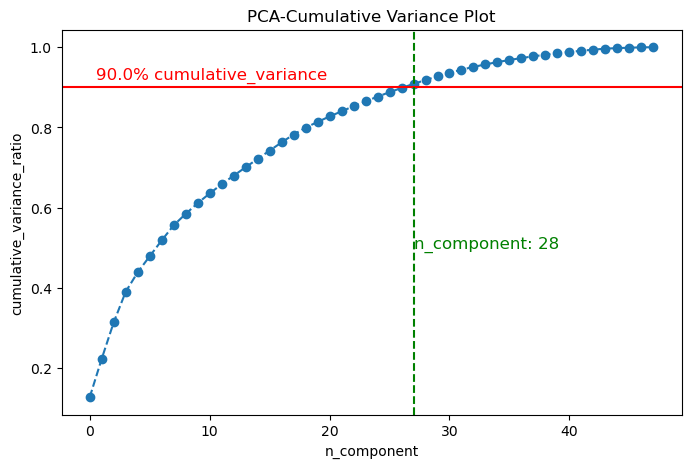

In [152]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# PCA 모델 설정: n_components를 최대로 설정하여 모든 주성분을 계산
pca = PCA()
pca.fit(x_train_zscale, y_train)

# 설명된 분산의 누적합 계산
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# 설명된 분산의 누적합이 특정 임계값(예: 0.95)을 넘는 지점 찾기
n_components = np.where(cumulative_variance_ratio > 0.9)[0][0] + 1

print(f"선택된 주성분의 개수: {n_components}")
print("누적 분산 설명 비율:", cumulative_variance_ratio)


# 설명된 분산의 누적합을 시각화
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('n_component')
plt.ylabel('cumulative_variance_ratio')
plt.title('PCA-Cumulative Variance Plot')

# 누적합이 특정 임계값(예: 0.95)을 넘는 지점에 세로선 추가
threshold = 0.9
plt.axhline(y=threshold, color='r', linestyle='-')
plt.text(0.5, threshold + 0.02, f'{threshold*100}% cumulative_variance', color = 'red', fontsize=12)

# 주성분 개수 결정을 위한 세로선 추가
plt.axvline(x=n_components - 1, color='g', linestyle='--')
plt.text(n_components - 1, 0.5, f'n_component: {n_components}', color = 'green', fontsize=12)

plt.show()


In [156]:
from sklearn.decomposition import PCA

pca = PCA(n_components=28)
pca.fit(x_train_zscale, y_train)
x_train_pca = pca.transform(x_train_zscale)
x_val_pca = pca.transform(x_val_zscale)
x_test_pca = pca.transform(x_test_zscale)

for n_estimator in [1, 50, 100, 200, 300]:
    rf_regressor = RandomForestRegressor(n_estimators=n_estimator, random_state=0)
    rf_regressor.fit(x_train_pca, y_train)
    y_pred_rf = rf_regressor.predict(x_val_pca)
    mse = mean_squared_error(y_val, y_pred_rf)
    print(f"{n_estimator, mse}")

(1, 3.288016132542286)
(50, 1.487626243895612)
(100, 1.474807202432873)
(200, 1.4659124857329833)
(300, 1.4628786238004001)


In [160]:
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
rf_regressor.fit(x_train_pca, y_train)
y_pred_pca = rf_regressor.predict(x_test_pca)
mse = mean_squared_error(y_test, y_pred_pca)
print(f"{mse}")

1.5455178640416352


In [159]:
# LightGBM 모델 설정
lgbm_model = lgb.LGBMRegressor(num_leaves=256, max_depth=8, learning_rate=0.01, n_estimators=500)

multioutput_model = MultiOutputRegressor(lgbm_model)
multioutput_model.fit(x_train_pca, y_train)

y_pred_lgb = multioutput_model.predict(x_test_pca)


mse = mean_squared_error(y_test, y_pred_lgb, multioutput='uniform_average')
print(f'Mean Squared Error: {mse}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 23763, number of used features: 28
[LightGBM] [Info] Start training from score 1.352875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

## **모델**

## **결론**